In [1]:
import asdf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns
sns.set_theme(style="white", palette="muted", font_scale=0.8)

import mpl_fontkit as fk
fk.install("Inter")         # downloads Inter from Google Fonts
fk.set_font("Inter") 
# Set the default font size for all plots
plt.rcParams['font.size'] = 10

textwidth = 6.32283  # inches from 455,24411 pt textwidth in the document
# set default figure width to textwidth
plt.rcParams['figure.figsize'] = (textwidth, textwidth * 0.618)  # golden ratio
plt.rcParams['figure.dpi'] = 300  # high-quality output


class Experiment:
    """
    Handles loading of ASDF file and provides lazy-loaded properties for observations,
    dones, dt, trajectory, and derived metrics while keeping the file open.
    """
    def __init__(self, file_path: str):
        self._file_path = file_path
        self._af = asdf.open(file_path)
        self._obs = None
        self._dones = None
        self._dt = None
        self._trajectory = None
        self._first_dones = None
        self._env_config = None

    def __del__(self):
        try:
            self._af.close()
        except Exception:
            pass

    @property
    def obs(self) -> np.ndarray:
        if self._obs is None:
            self._obs = np.array(self._af['flights'][0]['agents']['agent_0']['observations'])
        return self._obs

    @property
    def dones(self) -> np.ndarray:
        if self._dones is None:
            self._dones = np.array(self._af['flights'][0]['global']['dones'])
        return self._dones
    
    @property
    def env_config(self) -> dict:
        if self._env_config is None:
            self._env_config = self._af['flights'][0]['metadata']['env_config']
        return self._env_config

    @property
    def dt(self) -> float:
        if self._dt is None:
            self.policy_freq = self.env_config['policy_freq']
            self._dt =  1.0 / self.policy_freq
        return self._dt

    @property
    def trajectory(self) -> np.ndarray:
        if self._trajectory is None:
            self._trajectory = np.array(self._af['flights'][0]['global']['trajectory'])
        return self._trajectory

    @property
    def time(self) -> np.ndarray:
        return np.arange(self.obs.shape[0]) * self.dt

    @property
    def first_dones(self) -> np.ndarray:
        if self._first_dones is None:
            self._first_dones = np.argmax(self.dones, axis=0)
        return self._first_dones

    @property
    def full_runs(self) -> np.ndarray:
        return np.where(self.first_dones > 2000)[0]

    @property
    def failed_runs(self) -> np.ndarray:
        return np.where(self.first_dones <= 2000)[0]

    @property
    def payload(self) -> np.ndarray:
        return self.obs[:, :, 0:3]

    @property
    def payload_velocity(self) -> np.ndarray:
        return self.obs[:, :, 3:6]

    @property
    def other_quads(self) -> np.ndarray:
        return self.obs[:, :, 6:9]

    @property
    def q_pos(self) -> np.ndarray:
        return self.obs[:, :, 9:12]

    @property
    def q_rot_mat(self) -> np.ndarray:
        return self.obs[:, :, 12:21]

    @property
    def q_linvel(self) -> np.ndarray:
        return self.obs[:, :, 21:24]

    @property
    def q_angvel(self) -> np.ndarray:
        return self.obs[:, :, 24:27]

    @property
    def q_linacc(self) -> np.ndarray:
        return self.obs[:, :, 27:30]

    @property
    def q_angacc(self) -> np.ndarray:
        return self.obs[:, :, 30:33]

    @property
    def q_last_action(self) -> np.ndarray:
        return self.obs[:, :, 33:36]

    def info(self):
        """
        Print detailed information about the experiment, including data shapes,
        run counts, and timing.
        """
        print(f"File path: {self._file_path}")
        print(f"Timesteps: {self.obs.shape[0]}")
        print(f"Runs: {self.obs.shape[1]}")
        print(f"Time step (dt): {self.dt}")
        print(f"Total duration: {self.time[-1]:.3f} seconds")
        print(f"First done indices per run: {self.first_dones}")
        n_full = len(self.full_runs)
        print(f"Full runs (>2000 steps): {n_full}/{self.obs.shape[1]} ({n_full/self.obs.shape[1]*100:.2f}%)")
        print("Observation channel shapes:")
        print(f"  payload: {self.payload.shape}")
        print(f"  payload_velocity: {self.payload_velocity.shape}")
        print(f"  other_quads: {self.other_quads.shape}")
        print(f"  q_pos: {self.q_pos.shape}")
        print(f"  q_rot_mat: {self.q_rot_mat.shape}")
        print(f"  q_linvel: {self.q_linvel.shape}")
        print(f"  q_angvel: {self.q_angvel.shape}")
        print(f"  q_linacc: {self.q_linacc.shape}")
        print(f"  q_angacc: {self.q_angacc.shape}")
        print(f"  q_last_action: {self.q_last_action.shape}")




Font name: `Inter`


In [22]:
# Plot functions (unchanged)

def plot_3d_final_positions(exp: Experiment, width: float = textwidth):
    fig = plt.figure(figsize=(width, width))
    ax = fig.add_subplot(111, projection='3d')
    final = exp.payload[-1]
    xs, ys, zs = final[:, 0], final[:, 1], final[:, 2]
    ax.scatter(xs, ys, zs, c=range(final.shape[0]), cmap='viridis', depthshade=True)
    for idx in exp.full_runs:
        path = exp.payload[:, idx, :]
        ax.plot(path[:, 0], path[:, 1], path[:, 2], alpha=0.5)
    ax.set(xlabel='X', ylabel='Y', zlabel='Z', title='Final Payload in 3D')
    return fig


def plot_xy_plane(exp: Experiment, width: float = textwidth):
    fig, ax = plt.subplots(figsize=(width, width * 0.618))
    ax.plot(exp.trajectory[:, 0], exp.trajectory[:, 1], color='gray', alpha=0.5, linewidth=1)
    for idx in exp.full_runs:
        path = exp.trajectory - exp.payload[:, idx, :]
        sc = ax.scatter(path[:, 0], path[:, 1], c=exp.time, cmap='crest', s=1, alpha=0.6)
    start = exp.trajectory[0] - exp.payload[0, exp.full_runs[0], :]
    ax.scatter(start[0], start[1], s=50, label='Start', marker='o')
    for idx in exp.full_runs:
        q1 = start + exp.q_pos[0, idx, :]
        q2 = start + exp.other_quads[0, idx, :]
        ax.scatter(*q1[:2], s=50, marker='x')
        ax.scatter(*q2[:2], s=50, marker='x')
        ax.plot([start[0], q1[0]], [start[1], q1[1]], '--', linewidth=0.5)
        ax.plot([start[0], q2[0]], [start[1], q2[1]], '--', linewidth=0.5)
    ax.set_aspect('equal', 'box')
    fig.colorbar(sc, ax=ax, label='Time [s]')
    ax.set(xlabel='X', ylabel='Y', title='Payload XY Plane')
    return fig


def plot_payload_error_time(exp: Experiment, width: float = textwidth):
    fig, ax = plt.subplots(figsize=(width, width * 0.618))
    t = exp.time
    for i in range(3):
        ax.plot(t, exp.payload[:, 0, i], label=f'Error {i}')
    ax.set(xlabel='Time [s]', ylabel='Error', title='Payload Error Over Time')
    ax.legend()
    return fig


def plot_linear_velocity_norm(exp: Experiment, width: float = textwidth):
    linvel_norm = np.linalg.norm(exp.q_linvel, axis=2)
    fig, ax = plt.subplots(figsize=(width, width * 0.618))
    for r in range(linvel_norm.shape[1]):
        end = exp.first_dones[r]
        ax.plot(exp.time[:end], linvel_norm[:end, r], alpha=0.3)
    ax.set(xlabel='Time [s]', ylabel='||LinVel||', title='Linear Velocity Norm')
    return fig


def plot_error_percentiles(exp: Experiment, width: float = textwidth):
    max_t = min(2046, exp.payload.shape[0])
    norms = np.linalg.norm(exp.payload[:max_t], axis=2)
    percentiles = [0,25,50,75,100]
    fig, ax = plt.subplots(figsize=(width, width * 0.618))
    for p in percentiles:
        ax.plot(exp.time[:max_t], np.percentile(norms, p, axis=1), label=f'{p}th')
    hist, bins = np.histogram(exp.first_dones * exp.dt, bins=20)
    ax.bar(bins[:-1], hist/hist.max(), width=np.diff(bins), alpha=0.7)
    ax.set(xlabel='Time [s]', ylabel='Error Norm / Freq', title='Error Percentiles & Termination')
    ax.legend()
    return fig


def plot_avg_payload_speed(exp: Experiment, width: float = textwidth):
    speeds = np.linalg.norm(exp.payload_velocity, axis=2)
    avg = speeds.mean(axis=1)
    fig, ax = plt.subplots(figsize=(width, width * 0.618))
    ax.plot(exp.time, avg)
    ax.set(xlabel='Time [s]', ylabel='Speed', title='Avg Payload Speed')
    return fig


File path: ../experiments_data/2_quads_figure_eight_20250625_150245/2_quads_figure_eight.crazy.asdf
Timesteps: 5000
Runs: 100
Time step (dt): 0.004
Total duration: 19.996 seconds
First done indices per run: [4378 2101 2400 2268 4999  399 1321 1241 2205 2117 4999 2289 4999 2309
 4804 4999 4999 3836 4999 4999 2275 4999 1247 4999 3489 3025 3321 1856
 2364 1131 4412 4999 2510 1537  418 4999 2448 2632 2328 2414 4999 4999
 4999 4999 4999   67 2259 4999 2323 4999 2713 2098 4999 4999 1724 2428
 2248  820 2812 2421 2259  447 4999 2279 4538 4999 1115 2267   65 1129
 4999 4999 4999 2343 2470 3684 3528 4326 1450 3309 2688  101 2548 4999
 4999 2277 2428 3375 4999 4705 2285 4999 2421 4999 4999  119 4999  917
 1068 1255]
Full runs (>2000 steps): 79/100 (79.00%)
Observation channel shapes:
  payload: (5000, 100, 3)
  payload_velocity: (5000, 100, 3)
  other_quads: (5000, 100, 3)
  q_pos: (5000, 100, 3)
  q_rot_mat: (5000, 100, 9)
  q_linvel: (5000, 100, 3)
  q_angvel: (5000, 100, 3)
  q_linacc: (5000,

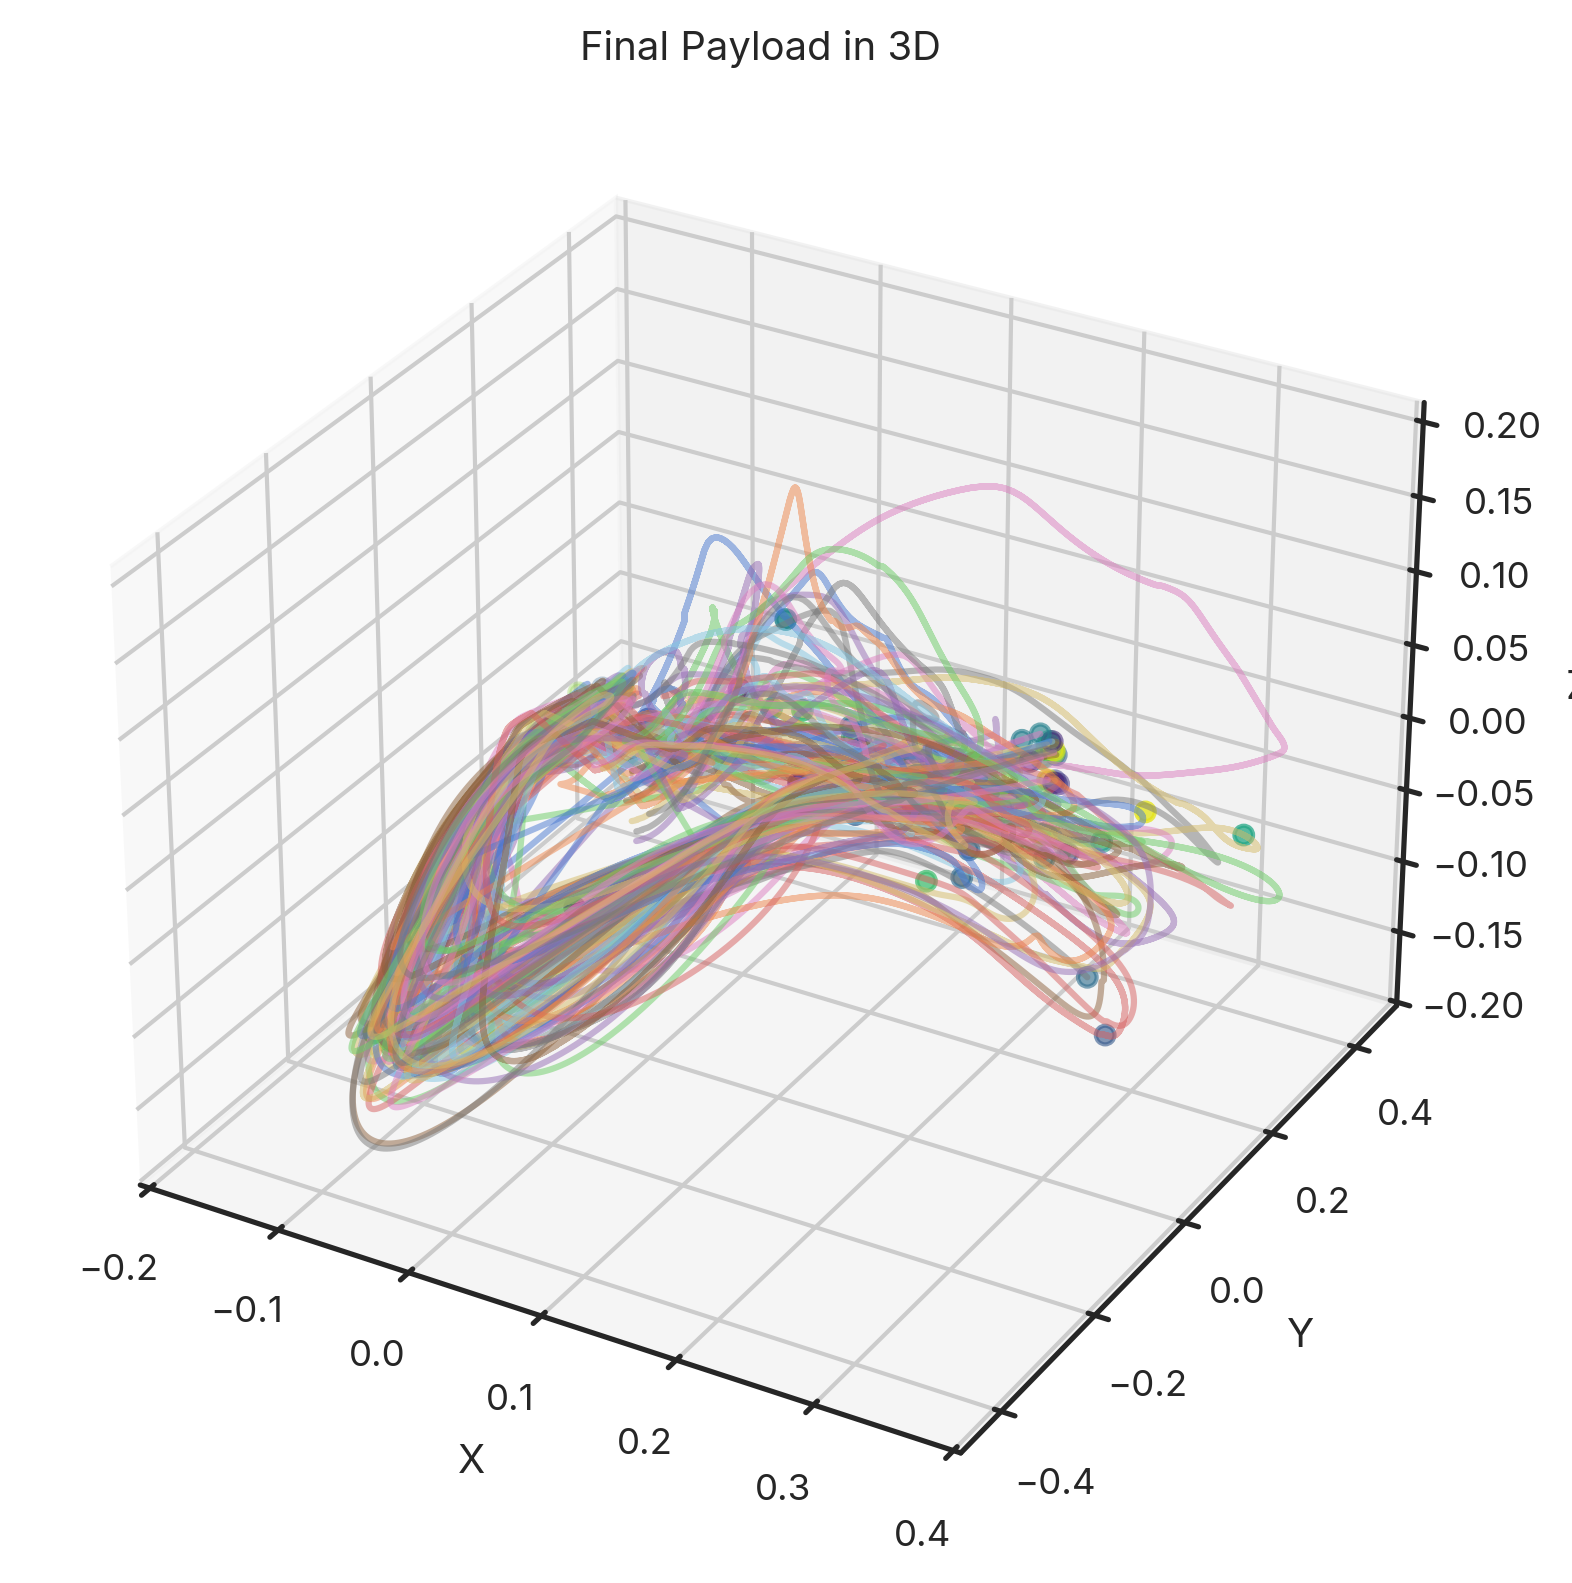

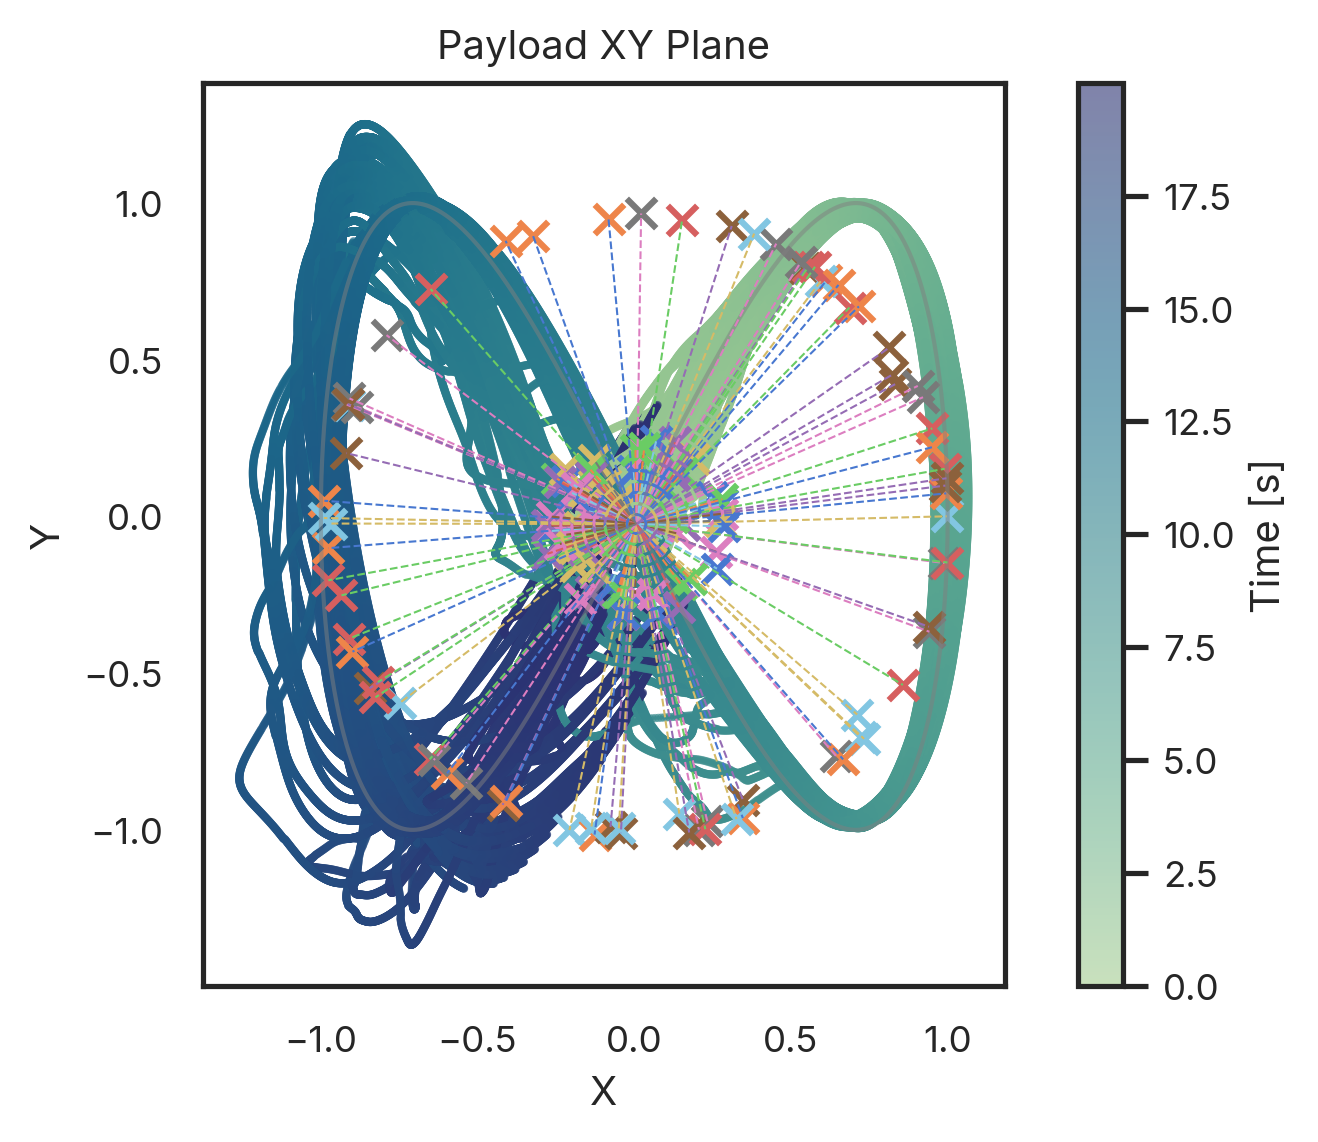

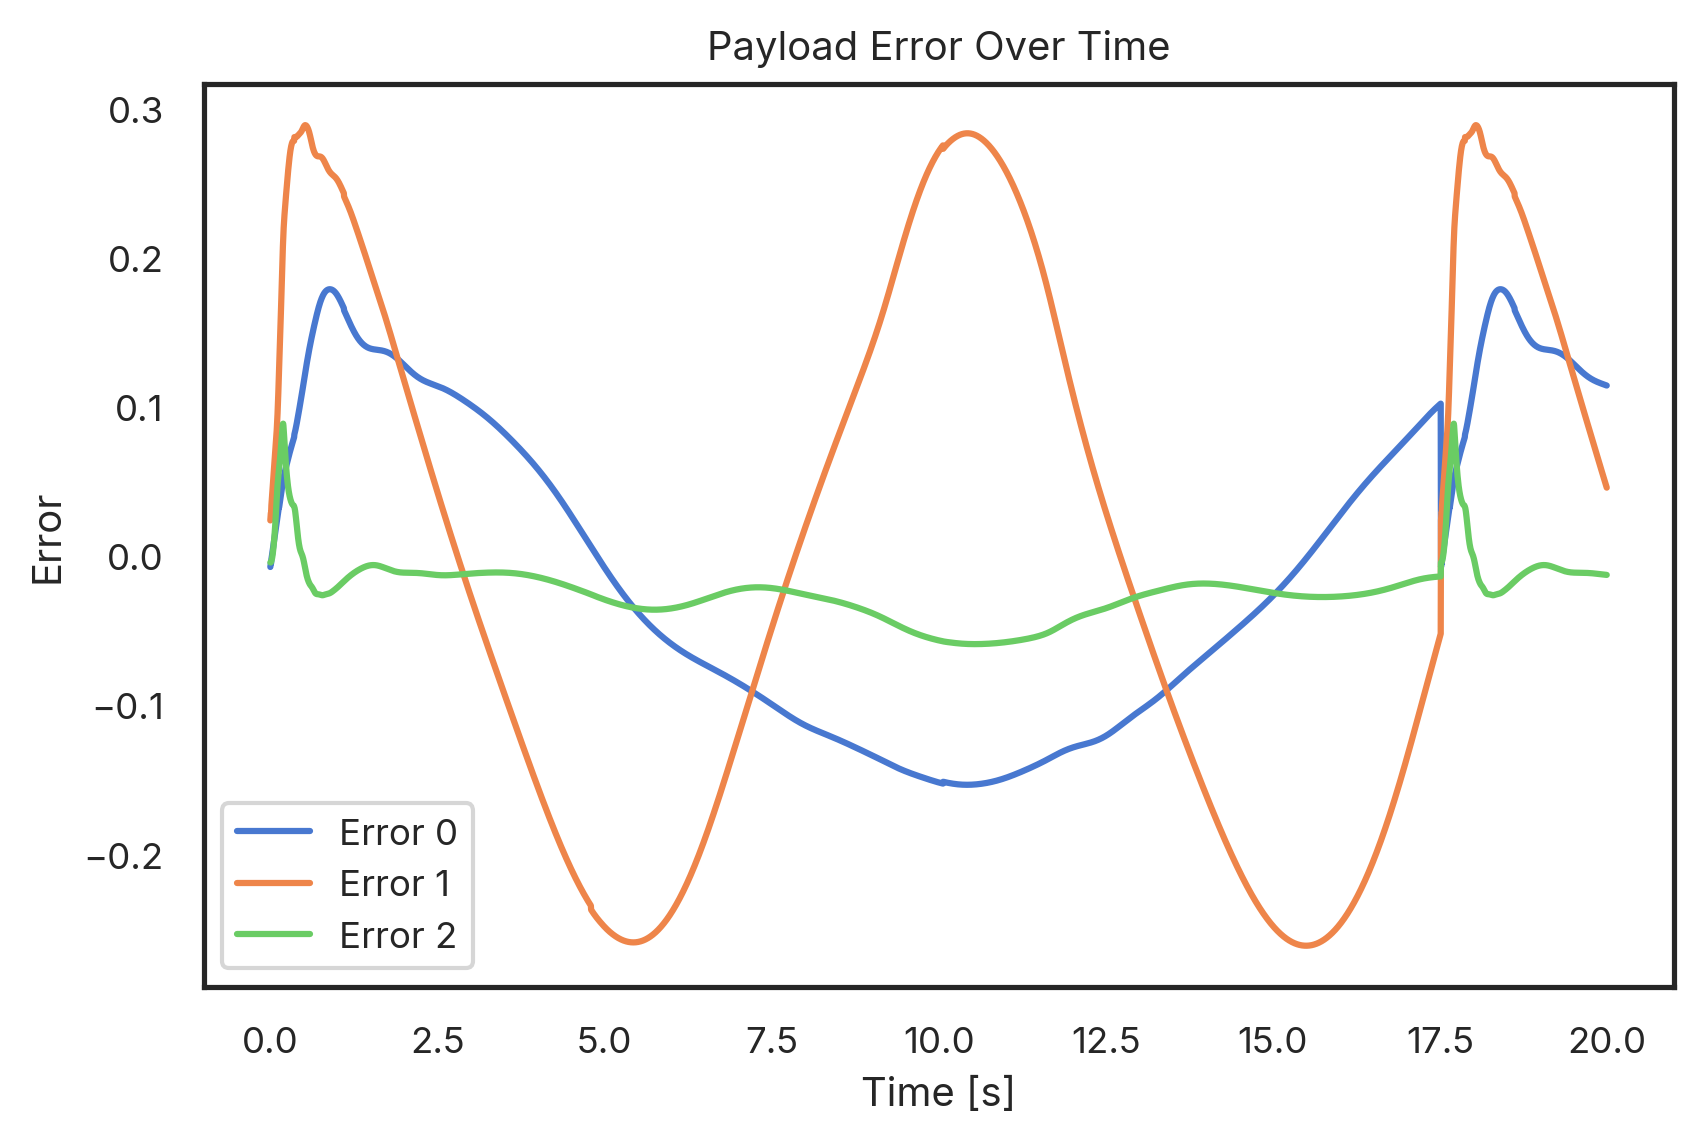

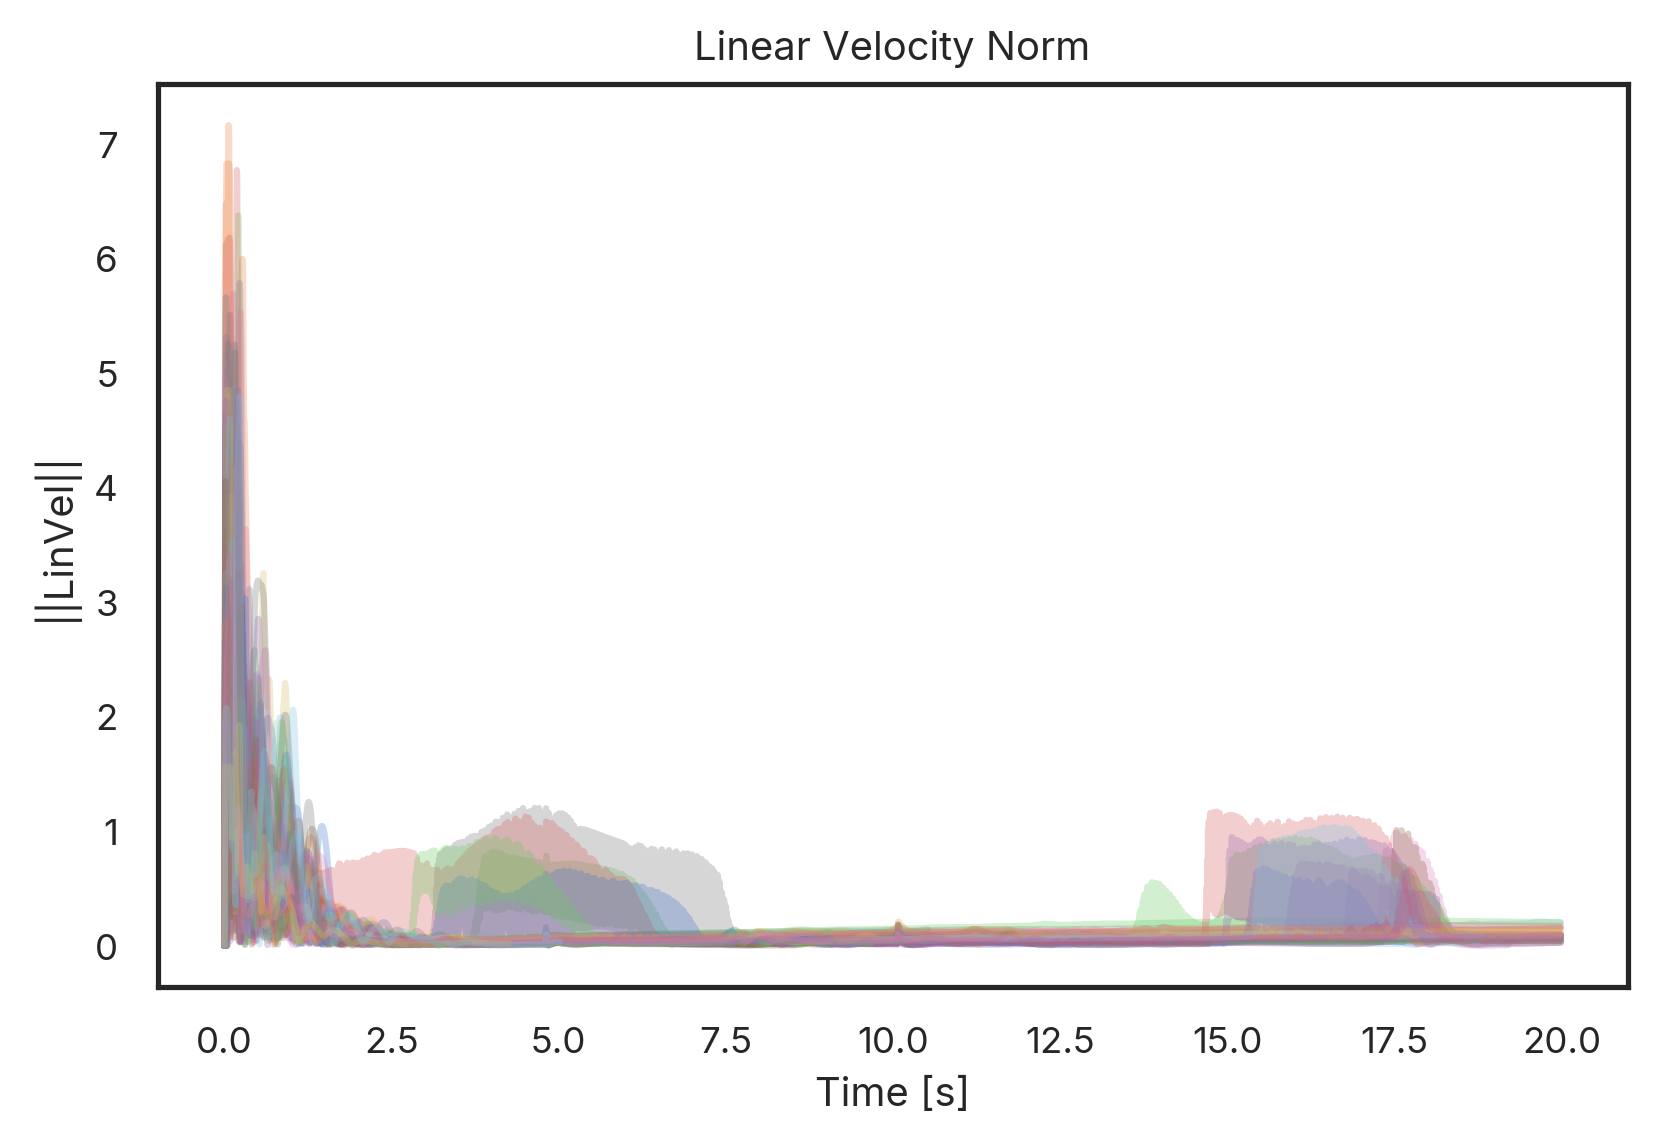

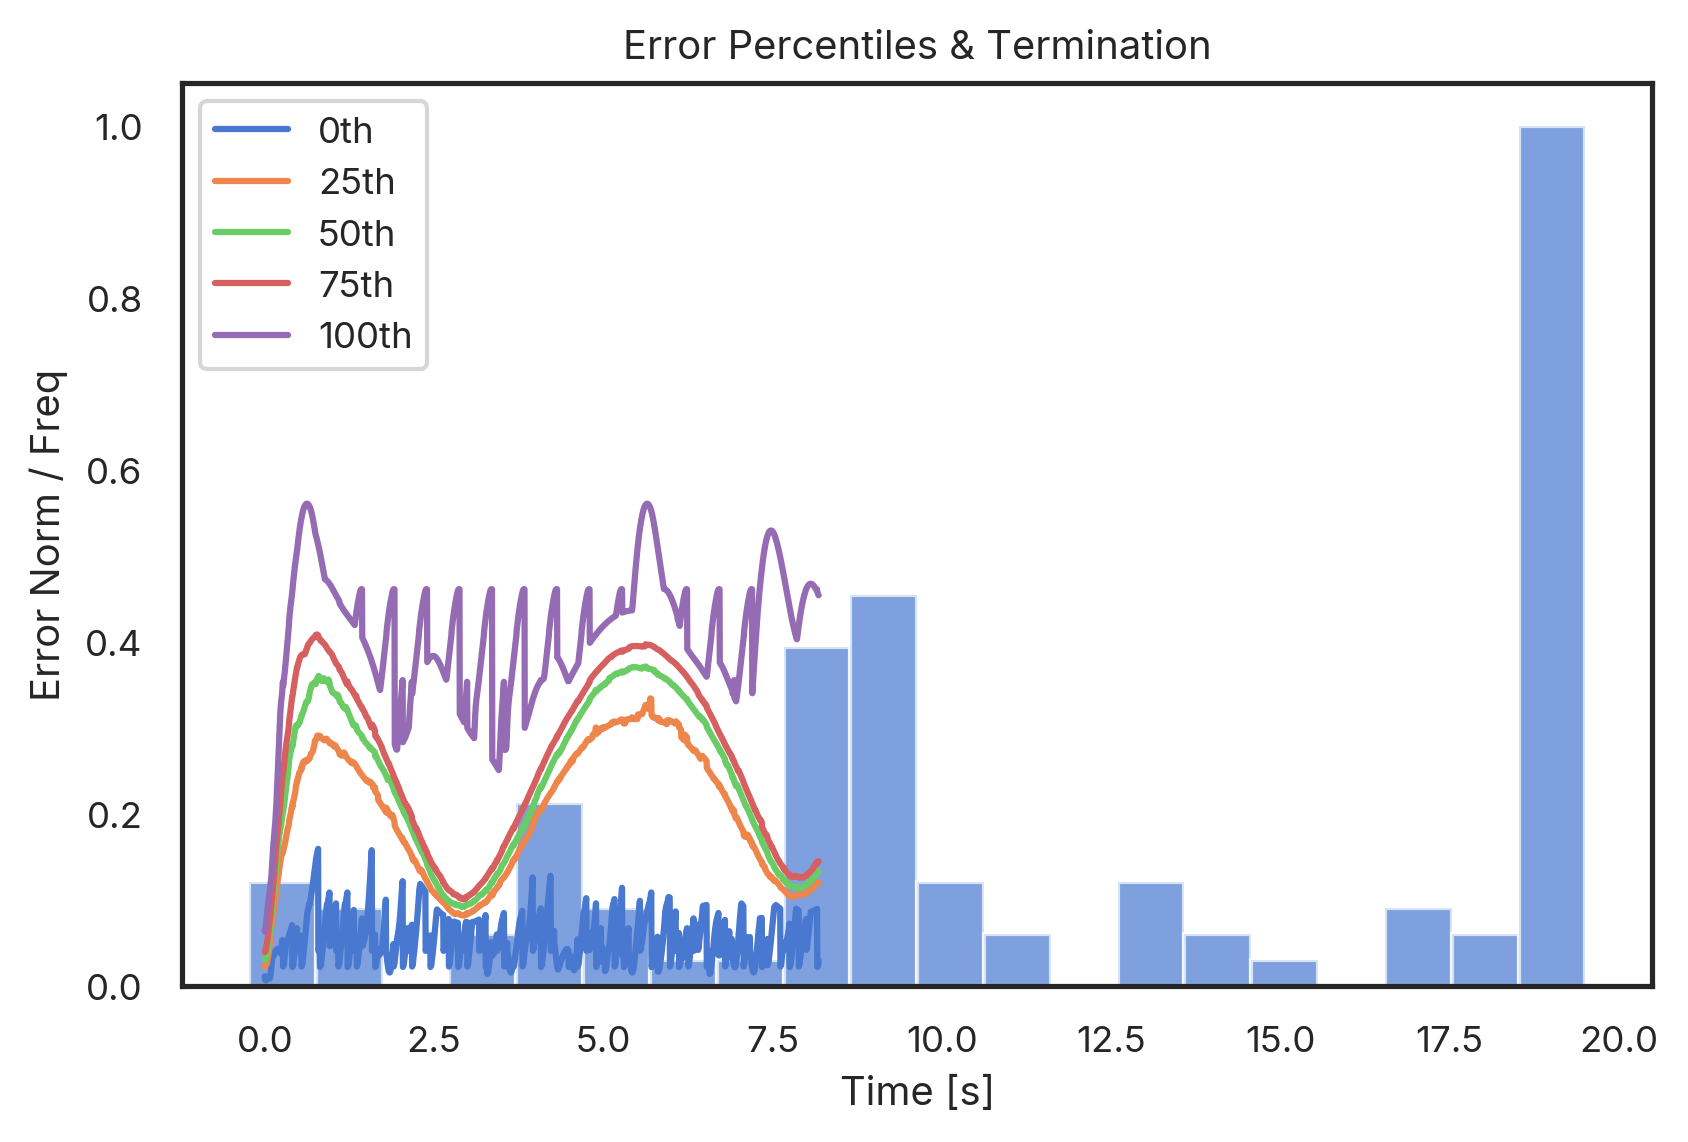

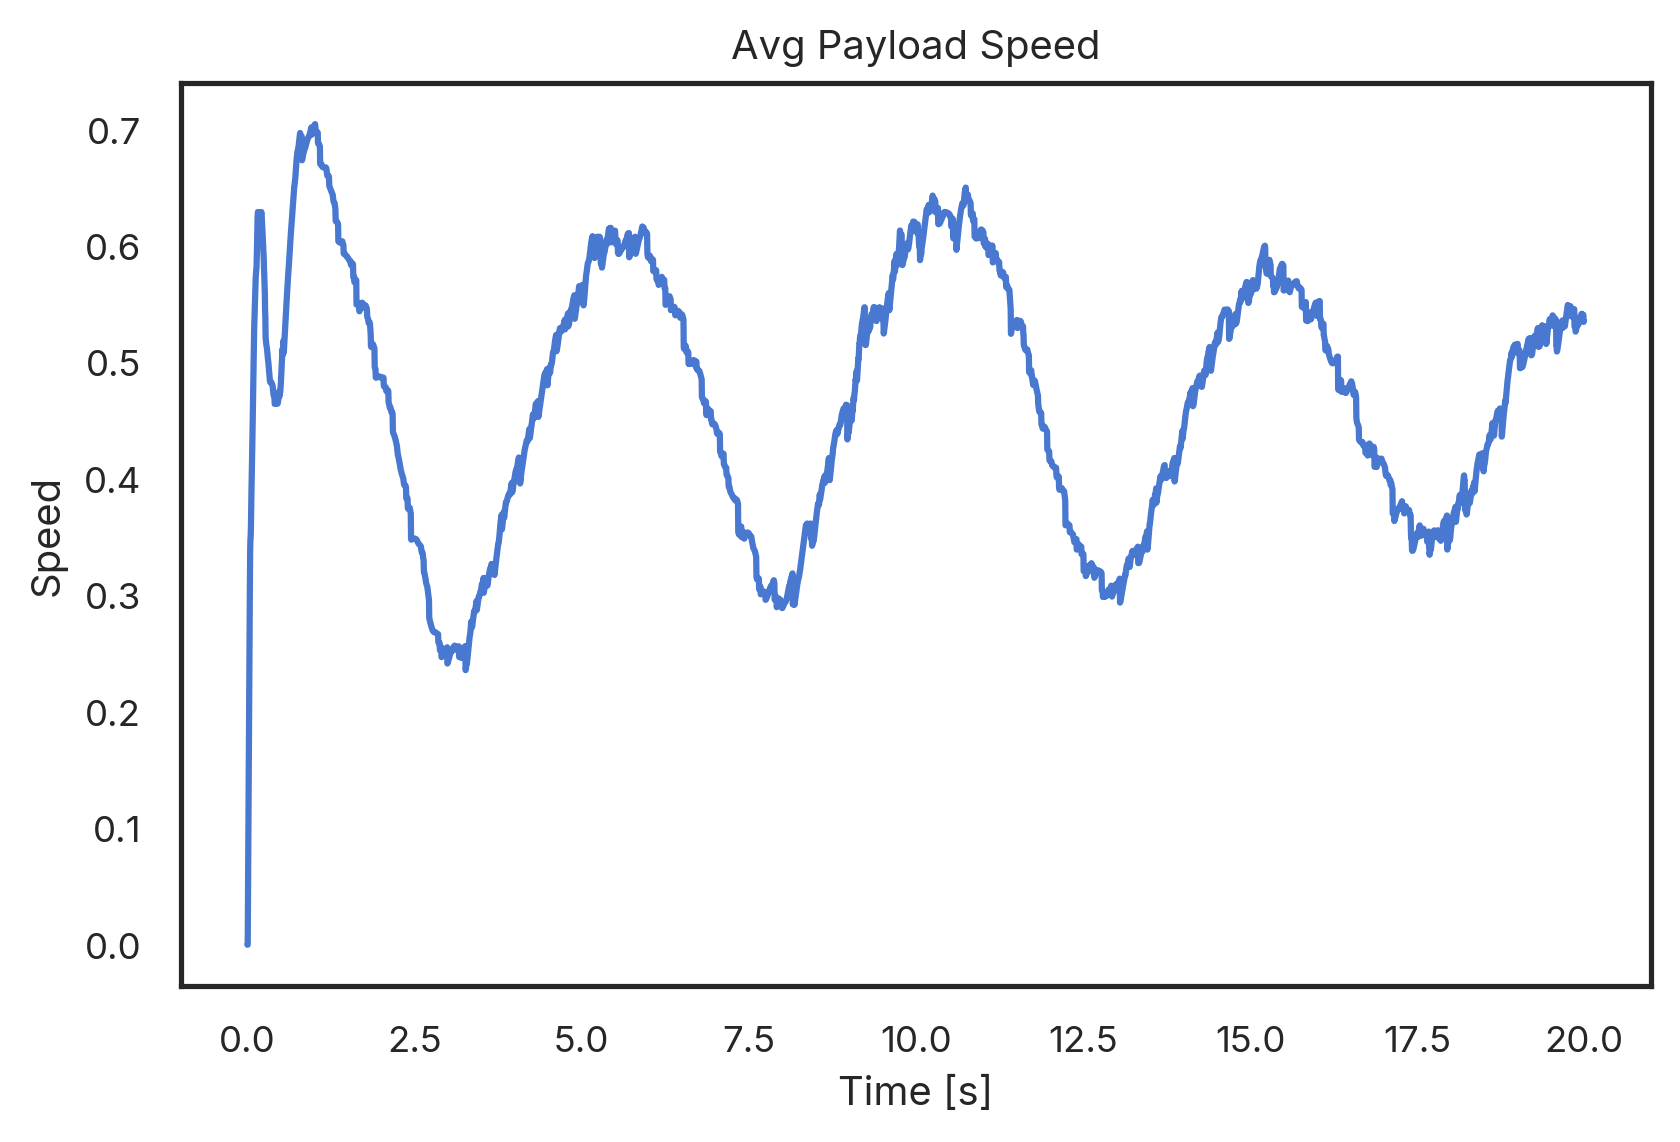

In [ ]:
exp = Experiment('../experiments_data/2_quads_figure_eight_20250625_150245/2_quads_figure_eight.crazy.asdf')
exp.info()


plot_3d_final_positions(exp)
plot_xy_plane(exp)
plot_payload_error_time(exp)
plot_linear_velocity_norm(exp)
plot_error_percentiles(exp)
plot_avg_payload_speed(exp)
plt.show()

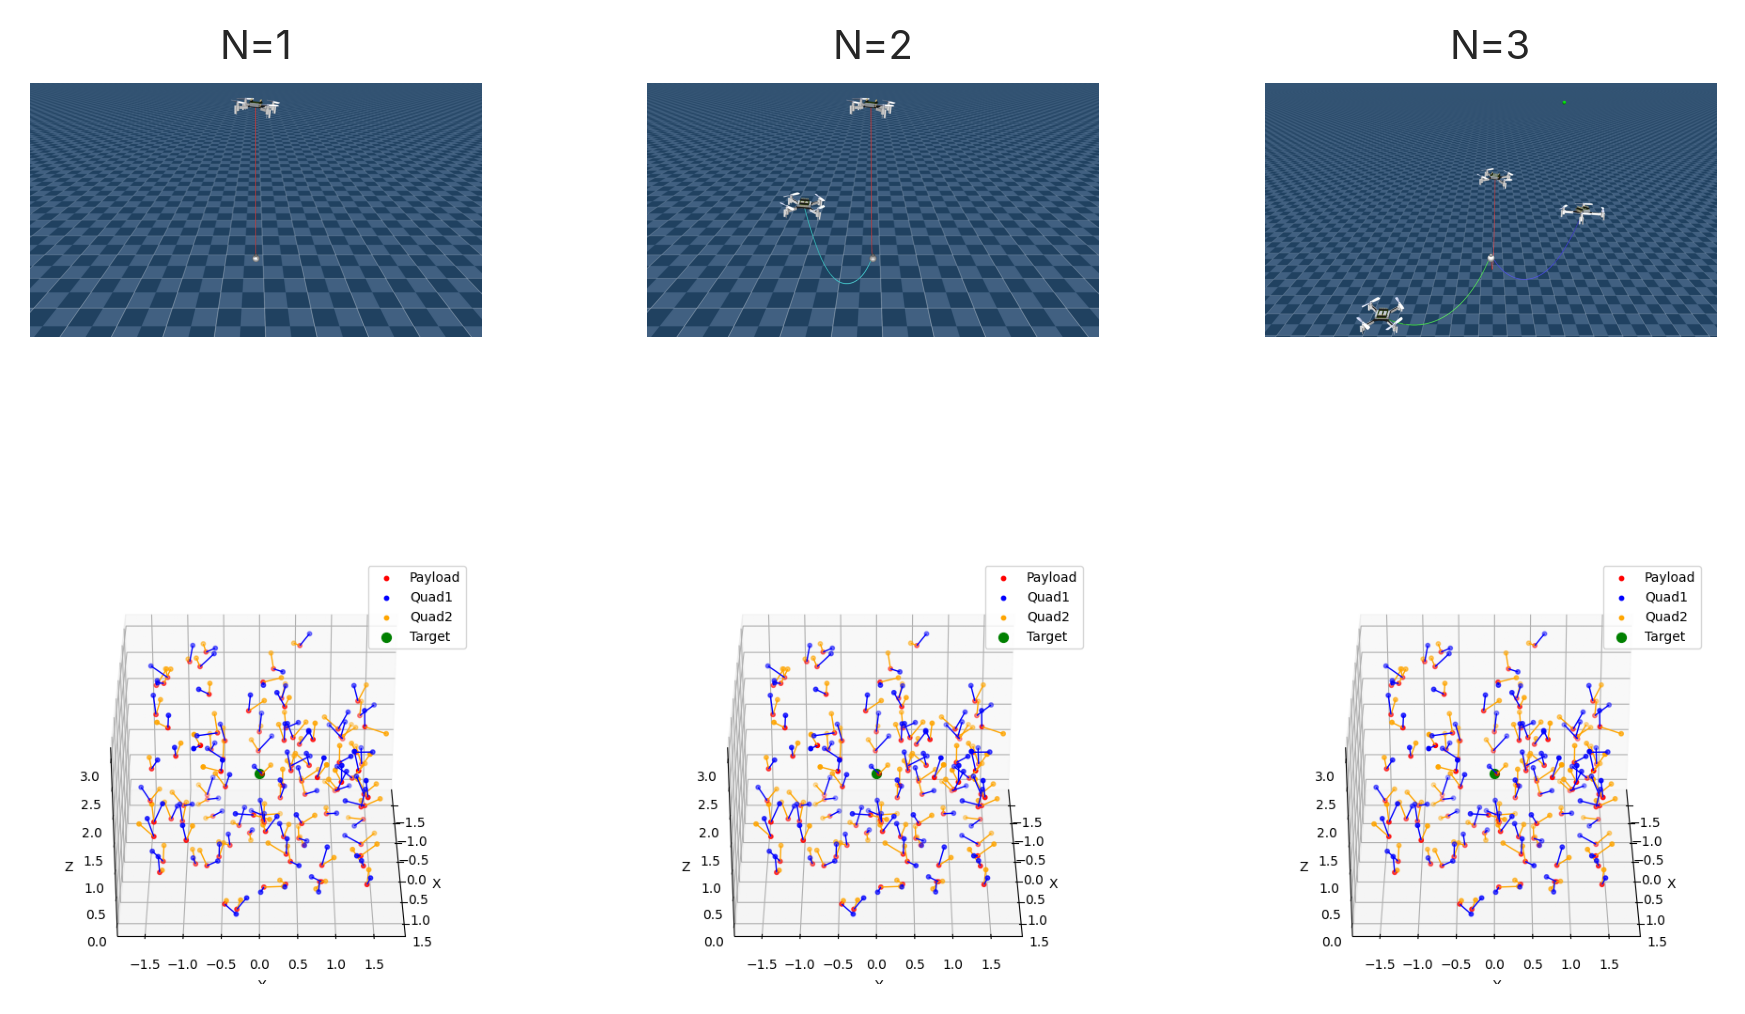

In [ ]:
# Plot initial conditions
experiments_data = [
    '1_quads_recovery_20250619_230918',
    '2_quads_recovery_20250619_231158',
    '3_quads_recovery_20250619_231510']

image_paths = [
    f'../experiments_data/{exp_name}/images/{exp_name[0]}_quads_recovery_first_frame.png'
    for exp_name in experiments_data
]

fig, axs = plt.subplots(2, len(image_paths), figsize=(textwidth, textwidth * 0.618))
fig.tight_layout()

# top row: experiment first frames
for ax, img_path, exp_name in zip(axs[0], image_paths, experiments_data):
    num_quads = exp_name[0]
    img = plt.imread(img_path)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f'N={num_quads}')

# bottom row: placeholder
placeholder_img = plt.imread('../placeholder_initial.png')
for ax in axs[1]:
    ax.imshow(placeholder_img)
    ax.axis('off')

plt.savefig('plots/initial_conditions.png', bbox_inches='tight', dpi=300)